# Validation

OpenFisca-UK runs unit and integration tests on each new version (see [here](https://github.com/PSLmodels/openfisca-uk/tree/master/tests)).
In addition, the table below shows the aggregates produced by the model for the major taxes and benefits, and comparisons with UKMOD (latest [country report](https://www.iser.essex.ac.uk/research/publications/working-papers/cempa/cempa2-22.pdf)) and official sources.[^1]
UKMOD and administrative sources refer to 2018, and OpenFisca-UK is simulated on policy at the end of 2018.
Numbers are in billions of pounds.

[^1]: From the UKMOD country report: unless otherwise specified: Department for Work and Pensions https://www.gov.uk/government/publications/benefit-expenditure-and-caseload-tables-2018 ; Best Start Grant: https://www2.gov.scot/Topics/Statistics/Browse/Social-Welfare/SocialSecurityforScotland/BSGJune2019; Child tax credit and working tax credit: HMRC statistics 
https://www.gov.uk/government/statistics/child-and-working-tax-credits-statistics-finalised-annual-awards-2016-to-2017; Scottish Child Payment: Scottish Fiscal Commission https://www.fiscalcommission.scot/forecast/supplementary-costing-scottish-child-payment; Scottish Child Winter Heating Assistance: Scottish Fiscal Commission 
https://www.fiscalcommission.scot/forecast/supplementary-costing-child-winter-heating-assistance; Income tax: HMRC statistics https://www.gov.uk/government/statistics/income-tax-liabilities-statistics-tax-year-2014-to-2015-to-tax-year-2017-to-2018; National Insurance Contributions: ONS Blue Book Table 5.2.4s 

## Aggregate tables

OpenFisca-UK uprates input FRS data: below are comparisons between the aggregates calculated by OpenFisca-UK, UKMOD and external sources.

### Aggregates in full

In [13]:
import numpy as np
import pandas as pd
from openfisca_uk import (
    Microsimulation,
    variables as default_variables,
    REPO,
    parameters,
    CalibratedFRS,
)
from openfisca_core.parameters import ParameterNode
from pathlib import Path
import yaml
import plotly.express as px

OPENFISCA_UK = "OpenFisca-UK"
UKMOD = "UKMOD"
EXTERNAL = "External"

VARIABLES = [
    "child_benefit",
    "income_support",
    "JSA_income",
    "housing_benefit",
    "working_tax_credit",
    "child_tax_credit",
    "universal_credit",
    "pension_credit",
    "income_tax",
    "total_NI",
]

sim = Microsimulation(dataset=CalibratedFRS, average_parameters=True)

# https://stackoverflow.com/questions/34667108/ignore-dates-and-times-while-parsing-yaml

yaml.SafeLoader.yaml_implicit_resolvers = {
    k: [r for r in v if r[0] != "tag:yaml.org,2002:timestamp"]
    for k, v in yaml.SafeLoader.yaml_implicit_resolvers.items()
}

with open(
    REPO.parent
    / "docs"
    / "book"
    / "model"
    / "ukmod_country_report_statistics.yaml",
    mode="r",
) as f:
    ukmod_statistics = ParameterNode(
        "ukmod", data=yaml.load(f, Loader=yaml.SafeLoader)
    )


def process_scalar(x, divisor, decimals):
    if np.isnan(x):
        return x
    return round(x / divisor, decimals)


def model_validation_table(
    model_year_variable_to_result_func,
    title=None,
    start_year=2022,
    end_year=2025,
    divisor=1,
    decimals=0,
    models=[EXTERNAL, OPENFISCA_UK, UKMOD],
    variables=VARIABLES,
):
    dfs = []
    for model in models:
        df = pd.DataFrame(
            {
                year: {
                    default_variables[variable].label: process_scalar(
                        model_year_variable_to_result_func(
                            model, year, variable
                        ),
                        divisor,
                        decimals,
                    )
                    for variable in variables
                }
                for year in range(start_year, end_year + 1)
            }
        )
        dfs.append(df.T)
    return pd.concat(dfs, keys=models).replace(np.nan, "")


def budgetary_impact(model, year, variable):
    try:
        if model == OPENFISCA_UK:
            return sim.calc(variable, map_to="household", period=year).sum()
        elif model == UKMOD:
            return getattr(ukmod_statistics.ukmod.budgetary_impact, variable)(
                f"{year}-01-01"
            )
        elif model == EXTERNAL:
            return getattr(
                parameters.calibration.budgetary_impact.by_program, variable
            )(f"{year}-01-01")
    except:
        return np.nan

In [14]:
model_validation_table(budgetary_impact, divisor=1e9, decimals=1)

Child Benefit Income Support JSA (income-based)  \
External     2022  11.2           0.7            0.2                 
             2023  11.5           0.5            0.0                 
             2024  11.6           0.5            0.0                 
             2025  11.6           0.4            0.0                 
OpenFisca-UK 2022  12.0           0.8            0.2                 
             2023  12.0           0.6            0.1                 
             2024  11.9           0.4            0.1                 
             2025  12.0           0.2            0.1                 
UKMOD        2022  12.0                                              
             2023  12.3                                              
             2024  12.5                                              
             2025  12.6                                              

                   Housing Benefit  Working Tax Credit  Child Tax Credit  \
External     2022  15.9             1.6                 6.0                
             2023  14.7             1.2                 4.5                
             2024  12.5             0.8                 3.0                
             2025  10.2             0.4                 1.3                
OpenFisca-UK 2022  11.9             2.7                 7.8                
             2023  10.8             2.3                 6.2                
             2024  9.3              2.0                 4.8                
             2025  7.6              1.7                 3.7                
UKMOD        2022  10.3             1.6                 5.4                
             2023  9.6              1.3                 4.5                
             2024  8.5              0.9                 3.3                
             2025  6.7              0.4                 1.5                

                   Universal Credit  Pension Credit  Income Tax  \
External     2022  43.7              4.5             205.0        
             2023  49.8              4.4             215.0        
             2024  57.8              4.4             225.7        
             2025  68.0              4.2             237.5        
OpenFisca-UK 2022  40.6              3.1             203.3        
             2023  45.8              2.9             213.4        
             2024  53.3              2.8             224.0        
             2025  66.1              2.6             235.2        
UKMOD        2022  34.1              4.2             161.2        
             2023  39.1              4.4             170.6        
             2024  39.1              4.5             178.5        
             2025  45.6              4.5             187.9        

                   National Insurance (total)  
External     2022  151.3                       
             2023  157.5                       
             2024  164.6                       
             2025  172.1                       
OpenFisca-UK 2022  151.4                       
             2023  156.2                       
             2024  162.8                       
             2025  170.0                       
UKMOD        2022  156.0                       
             2023  145.1                       
             2024  147.9                       
             2025  151.9

### Forecast comparison

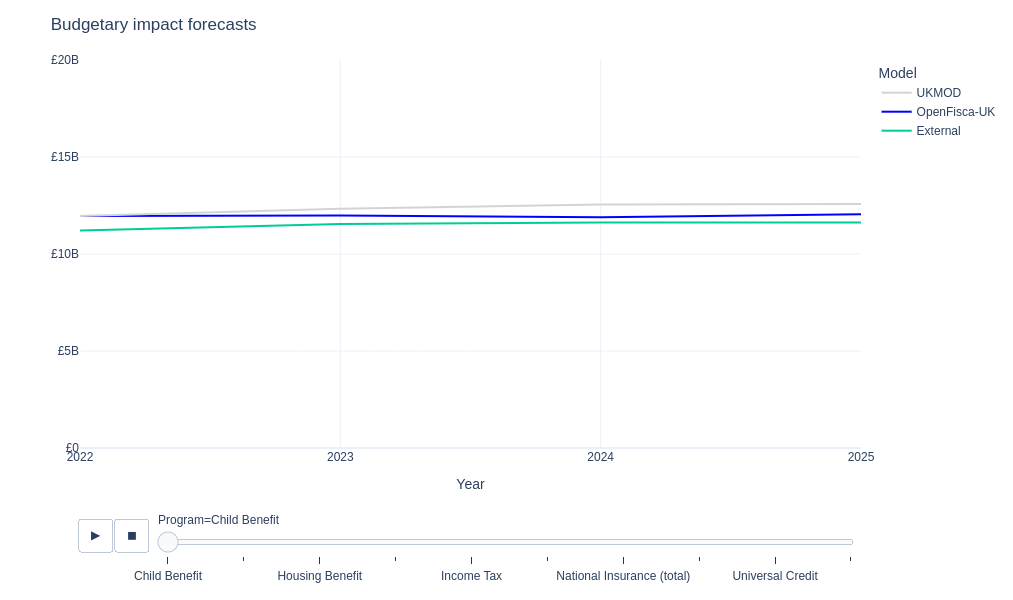

In [18]:
def table_to_model_comparison(table):
    df = table.reset_index()
    df.columns = ["Model", "Year"] + list(table.columns)
    return (
        pd.melt(df, id_vars=["Year", "Model"])
        .pivot(index=["Year", "variable"], columns="Model", values="value")
        .reset_index()
        .rename(columns=dict(variable="Program"))
    )


def tables_to_model_comparisons(tables):
    dfs = []
    for key, table in tables.items():
        df = table_to_model_comparison(table)
        df = df.rename(
            columns={
                column: f"{column} {key}"
                if key != "" and column not in ("Year", "Model", "Program")
                else column
                for column in df.columns
            }
        )
        dfs.append(df)
    df = pd.concat(dfs, axis=1)
    df = df.loc[:, ~df.columns.duplicated()]
    return df


def model_forecast_chart(table, title=None, currency=True):
    hovertemplate = ""
    df = table_to_model_comparison(table)
    fig = (
        px.line(
            df,
            animation_frame="Program",
            x="Year",
            y=[EXTERNAL, OPENFISCA_UK, UKMOD],
            color_discrete_map={
                OPENFISCA_UK: "blue",
                UKMOD: "lightgrey",
            },
        )
        .update_layout(
            width=800,
            height=600,
            yaxis_tickprefix="£" if currency else "",
            title=title,
            template="plotly_white",
            legend_title="Model",
            yaxis_title="",
            yaxis_range=(0, 20e9) if currency else (0, 10e6),
            legend_traceorder="reversed",
            xaxis_tickvals=list(range(2022, 2026)),
        )
        .update_traces(hovertemplate=hovertemplate)
    )
    for frame in fig.frames:
        for data in frame.data:
            data.hovertemplate = hovertemplate
    return fig


model_forecast_chart(
    model_validation_table(budgetary_impact, divisor=1, decimals=1),
    title="Budgetary impact forecasts",
)

### Differences

#### Absolute

In [4]:
def budgetary_impact_error(model, year, variable):
    try:
        if model == OPENFISCA_UK:
            return sim.calc(
                variable, map_to="household", period=year
            ).sum() - budgetary_impact(EXTERNAL, year, variable)
        elif model == UKMOD:
            return getattr(ukmod_statistics.ukmod.budgetary_impact, variable)(
                f"{year}-01-01"
            ) - budgetary_impact(EXTERNAL, year, variable)
    except:
        return np.nan


model_validation_table(
    budgetary_impact_error,
    models=[OPENFISCA_UK, UKMOD],
    divisor=1e9,
    decimals=1,
)

Child Benefit Income Support JSA (income-based)  \
OpenFisca-UK 2022            0.7            0.1                0.0   
             2023            0.4            0.1                0.1   
             2024            0.3           -0.0                0.1   
             2025            0.4           -0.2                0.1   
             2026            0.4           -0.3                0.1   
UKMOD        2022            0.8                                     
             2023            0.8                                     
             2024            0.9                                     
             2025            1.0                                     
             2026            1.0                                     

                   Housing Benefit  Working Tax Credit  Child Tax Credit  \
OpenFisca-UK 2022             -4.0                 1.1               1.8   
             2023             -4.0                 1.1               1.7   
             2024             -3.3                 1.2               1.8   
             2025             -2.7                 1.3               2.3   
             2026             -2.1                 1.4               2.6   
UKMOD        2022             -5.6                -0.1              -0.6   
             2023             -5.1                 0.1               0.1   
             2024             -4.0                 0.1               0.3   
             2025             -3.5                 0.1               0.1   
             2026             -1.5                 0.4               1.2   

                   Universal Credit  Pension Credit  Income Tax  \
OpenFisca-UK 2022              -3.3            -1.3        -1.7   
             2023              -4.3            -1.5        -1.6   
             2024              -4.8            -1.6        -1.7   
             2025              -2.1            -1.7        -2.3   
             2026              -3.0            -1.7        -1.6   
UKMOD        2022              -9.6            -0.3       -43.8   
             2023             -10.6            -0.0       -44.4   
             2024             -18.6             0.1       -47.2   
             2025             -22.3             0.2       -49.6   
             2026             -32.2             0.3       -49.6   

                   National Insurance (total)  
OpenFisca-UK 2022                         0.1  
             2023                        -1.3  
             2024                        -1.8  
             2025                        -2.1  
             2026                         0.1  
UKMOD        2022                         4.7  
             2023                       -12.4  
             2024                       -16.7  
             2025                       -20.2  
             2026                       -20.2

#### Relative

In [5]:
def relative_budgetary_impact_error(model, year, variable):
    try:
        if model == OPENFISCA_UK:
            return (
                sim.calc(variable, map_to="household", period=year).sum()
                / budgetary_impact(EXTERNAL, year, variable)
                - 1
            )
        elif model == UKMOD:
            return (
                getattr(ukmod_statistics.ukmod.budgetary_impact, variable)(
                    f"{year}-01-01"
                )
                / budgetary_impact(EXTERNAL, year, variable)
                - 1
            )
    except:
        return np.nan


model_validation_table(
    relative_budgetary_impact_error,
    models=[OPENFISCA_UK, UKMOD],
    divisor=1e-2,
    decimals=1,
)

Child Benefit Income Support JSA (income-based)  \
OpenFisca-UK 2022            6.7           21.6               21.8   
             2023            3.8           24.6           694171.0   
             2024            2.3           -8.8                inf   
             2025            3.6          -46.1                inf   
             2026            3.4          -75.5                inf   
UKMOD        2022            6.7                                     
             2023            6.8                                     
             2024            7.9                                     
             2025            8.2                                     
             2026            8.4                                     

                   Housing Benefit  Working Tax Credit  Child Tax Credit  \
OpenFisca-UK 2022            -25.1                64.7              30.2   
             2023            -26.8                88.9              37.4   
             2024            -26.2               143.3              62.0   
             2025            -26.0               356.9             174.7   
             2026            -25.3              2112.8            1090.6   
UKMOD        2022            -35.0                -4.3             -10.2   
             2023            -34.7                 6.5               1.1   
             2024            -32.2                10.2              11.4   
             2025            -34.3                14.6               9.1   
             2026            -18.2               546.0             515.1   

                   Universal Credit  Pension Credit  Income Tax  \
OpenFisca-UK 2022              -7.5           -29.9        -0.8   
             2023              -8.5           -33.9        -0.8   
             2024              -8.3           -37.0        -0.7   
             2025              -3.1           -39.5        -1.0   
             2026              -3.9           -41.5        -0.7   
UKMOD        2022             -22.0            -7.0       -21.4   
             2023             -21.3            -0.8       -20.6   
             2024             -32.3             2.6       -20.9   
             2025             -32.8             5.8       -20.9   
             2026             -41.3             8.2       -20.9   

                   National Insurance (total)  
OpenFisca-UK 2022                         0.1  
             2023                        -0.8  
             2024                        -1.1  
             2025                        -1.2  
             2026                         0.0  
UKMOD        2022                         3.1  
             2023                        -7.9  
             2024                       -10.2  
             2025                       -11.8  
             2026                       -11.8

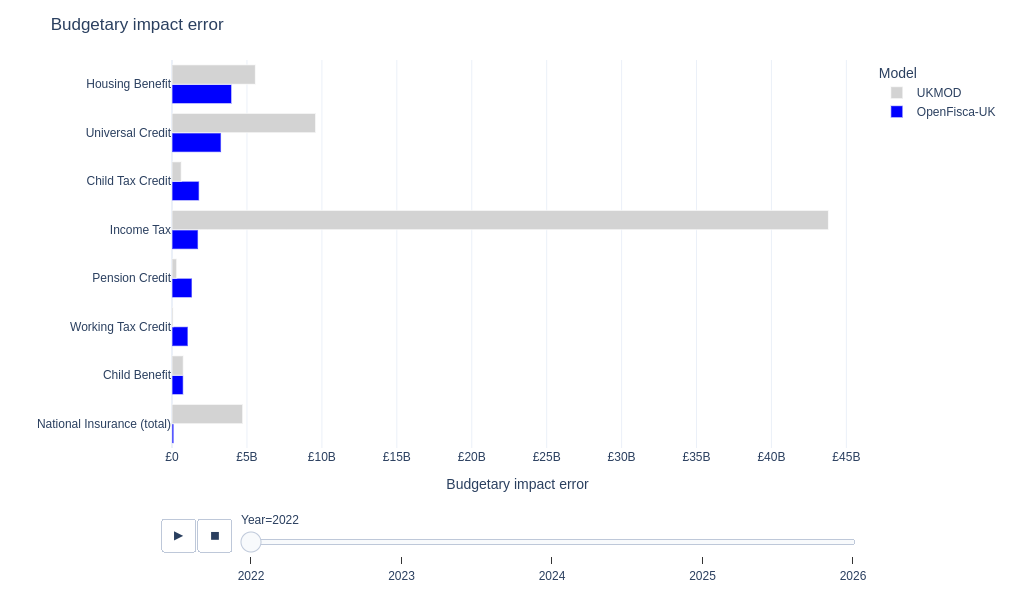

In [6]:
pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)


def error_chart(table, title=None):
    hovertemplate = "<b>%{customdata[4]} in %{customdata[3]}</b><br>Error: %{x}<br>Official: £%{customdata[2]}bn<br>OpenFisca-UK: £%{customdata[0]}bn<br>UKMOD: £%{customdata[1]}bn"
    table = table.replace("", np.nan).dropna(axis=0)
    table[[OPENFISCA_UK, UKMOD]] = table[[OPENFISCA_UK, UKMOD]].abs() / 1e2
    fig = (
        px.bar(
            table.sort_values(["Year", OPENFISCA_UK]),
            x=[OPENFISCA_UK, UKMOD],
            y="Program",
            orientation="h",
            animation_frame="Year",
            barmode="group",
            color_discrete_map={
                OPENFISCA_UK: "blue",
                UKMOD: "lightgrey",
            },
            custom_data=[
                "OpenFisca-UK budgetary impact",
                "UKMOD budgetary impact",
                "External budgetary impact",
                "Year",
                "Program",
            ],
        )
        .update_layout(
            width=800,
            height=600,
            xaxis_tickprefix="£",
            xaxis_title="Budgetary impact error",
            title=title,
            template="plotly_white",
            legend_title="Model",
            yaxis_title="",
            legend_traceorder="reversed",
        )
        .update_traces(hovertemplate=hovertemplate)
    )
    for frame in fig.frames:
        for data in frame.data:
            data.hovertemplate = hovertemplate
    return fig


error_chart(
    tables_to_model_comparisons(
        {
            "": model_validation_table(
                budgetary_impact_error,
                models=[OPENFISCA_UK, UKMOD],
                divisor=1e-2,
                decimals=1,
            ),
            "budgetary impact": model_validation_table(
                budgetary_impact, divisor=1e9, decimals=1
            ),
        }
    ),
    title="Budgetary impact error",
)

## Caseload tables

OpenFisca-UK uprates input FRS data: below are comparisons between the aggregates calculated by OpenFisca-UK, UKMOD and external sources.

### Caseloads in full

In [7]:
from microdf import MicroSeries


def get_nonzero(variable, year):
    entity = default_variables[variable].entity.key
    values = sim.calc(variable, period=year) > 0
    return MicroSeries(
        sim.map_to(values, entity, "household"),
        weights=sim.calc("household_weight", year),
    )


def caseload(model, year, variable):
    try:
        if model == OPENFISCA_UK:
            return get_nonzero(variable, year).sum()
        elif model == UKMOD:
            return getattr(ukmod_statistics.ukmod.nonzero_units, variable)(
                f"{year}-01-01"
            )
        elif model == EXTERNAL:
            try:
                return getattr(
                    parameters.calibration.families.by_program_participation,
                    variable,
                )(f"{year}-01-01")
            except:
                return getattr(
                    parameters.calibration.populations.by_program_participation,
                    variable,
                )(f"{year}-01-01")
    except:
        return np.nan


model_validation_table(
    caseload, models=[EXTERNAL, OPENFISCA_UK, UKMOD], divisor=1e6, decimals=2
)

Child Benefit Income Support JSA (income-based)  \
External     2022  7.07           0.16           0.04                
             2023  7.00           0.12           0.01                
             2024  6.93           0.08           0.0                 
             2025  6.87           0.03           0.0                 
             2026  6.80           0.0            0.0                 
OpenFisca-UK 2022  7.07           0.15           0.06                
             2023  7.01           0.11           0.03                
             2024  6.94           0.08           0.03                
             2025  6.87           0.04           0.03                
             2026  6.80           0.02           0.03                
UKMOD        2022  7.12                                              
             2023  7.07                                              
             2024  7.02                                              
             2025  6.99                                              
             2026  6.99                                              

                   Housing Benefit  Working Tax Credit  Child Tax Credit  \
External     2022  2.71             0.91                1.34               
             2023  2.46             0.79                1.06               
             2024  2.11             0.69                0.84               
             2025  1.73             0.60                0.67               
             2026  1.39             0.52                0.53               
OpenFisca-UK 2022  2.71             0.90                1.33               
             2023  2.46             0.78                1.05               
             2024  2.12             0.68                0.83               
             2025  1.73             0.59                0.66               
             2026  1.39             0.51                0.52               
UKMOD        2022  2.26             0.54                1.08               
             2023  2.05             0.44                0.89               
             2024  1.78             0.30                0.64               
             2025  1.43             0.13                0.29               
             2026  1.43             0.13                0.29               

                   Universal Credit  Pension Credit  Income Tax  \
External     2022  4.65              1.41            32.71        
             2023  5.05              1.34            33.22        
             2024  5.61              1.28            33.75        
             2025  6.29              1.23            34.28        
             2026  6.91              1.19            34.82        
OpenFisca-UK 2022  4.67              1.41            31.21        
             2023  5.07              1.34            31.32        
             2024  5.63              1.28            31.35        
             2025  6.30              1.23            31.41        
             2026  6.93              1.19            31.50        
UKMOD        2022  4.21              1.41            30.01        
             2023  4.66              1.45            30.58        
             2024  5.31              1.44            30.94        
             2025  6.15              1.42            31.47        
             2026  6.15              1.42            31.47        

                  National Insurance (total)  
External     2022                             
             2023                             
             2024                             
             2025                             
             2026                             
OpenFisca-UK 2022  27.55                      
             2023  27.55                      
             2024  27.63                      
             2025  27.53                      
             2026  27.91                      
UKMOD        2022  26.08                      
             2023  26.19                    

### Caseload forecasts

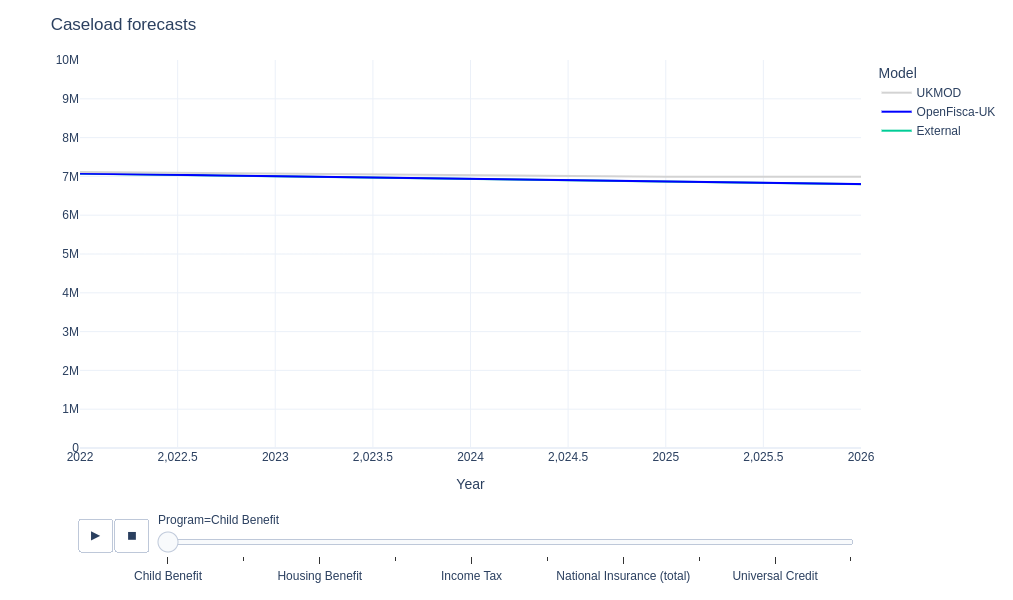

In [8]:
model_forecast_chart(
    model_validation_table(
        caseload, models=[EXTERNAL, OPENFISCA_UK, UKMOD], divisor=1, decimals=1
    ),
    title="Caseload forecasts",
    currency=False,
)

### Differences

#### Absolute

In [9]:
def caseload_error(model, year, variable):
    try:
        if model == OPENFISCA_UK:
            return get_nonzero(variable, year).sum() - caseload(
                EXTERNAL, year, variable
            )
        elif model == UKMOD:
            return getattr(ukmod_statistics.ukmod.nonzero_units, variable)(
                f"{year}-01-01"
            ) - caseload(EXTERNAL, year, variable)
    except:
        return np.nan


model_validation_table(
    caseload_error,
    variables=VARIABLES[:-1],
    models=[OPENFISCA_UK, UKMOD],
    divisor=1e6,
    decimals=1,
)

Child Benefit Income Support JSA (income-based)  \
OpenFisca-UK 2022  0.0           -0.0            0.0                 
             2023  0.0           -0.0            0.0                 
             2024  0.0            0.0            0.0                 
             2025  0.0            0.0            0.0                 
             2026  0.0            0.0            0.0                 
UKMOD        2022  0.0                                               
             2023  0.1                                               
             2024  0.1                                               
             2025  0.1                                               
             2026  0.2                                               

                   Housing Benefit  Working Tax Credit  Child Tax Credit  \
OpenFisca-UK 2022  0.0             -0.0                -0.0                
             2023  0.0             -0.0                -0.0                
             2024  0.0             -0.0                -0.0                
             2025  0.0             -0.0                -0.0                
             2026 -0.0             -0.0                -0.0                
UKMOD        2022 -0.4             -0.4                -0.3                
             2023 -0.4             -0.3                -0.2                
             2024 -0.3             -0.4                -0.2                
             2025 -0.3             -0.5                -0.4                
             2026  0.0             -0.4                -0.2                

                   Universal Credit  Pension Credit  Income Tax  
OpenFisca-UK 2022  0.0              -0.0            -1.5         
             2023  0.0              -0.0            -1.9         
             2024  0.0              -0.0            -2.4         
             2025  0.0               0.0            -2.9         
             2026  0.0              -0.0            -3.3         
UKMOD        2022 -0.4               0.0            -2.7         
             2023 -0.4               0.1            -2.6         
             2024 -0.3               0.2            -2.8         
             2025 -0.1               0.2            -2.8         
             2026 -0.8               0.2            -3.4

#### Relative

In [10]:
def relative_caseload_error(model, year, variable):
    try:
        if model == OPENFISCA_UK:
            return (
                get_nonzero(variable, year).sum()
                / caseload(EXTERNAL, year, variable)
                - 1
            )
        elif model == UKMOD:
            return (
                getattr(ukmod_statistics.ukmod.nonzero_units, variable)(
                    f"{year}-01-01"
                )
                / caseload(EXTERNAL, year, variable)
                - 1
            )
    except:
        return np.nan


model_validation_table(
    relative_caseload_error,
    variables=VARIABLES[:-1],
    models=[OPENFISCA_UK, UKMOD],
    divisor=1e-2,
    decimals=1,
)

Child Benefit Income Support JSA (income-based)  \
OpenFisca-UK 2022  0.0           -1.5            28.1                
             2023  0.1           -1.5            559.7               
             2024  0.1            1.3            inf                 
             2025  0.0            23.8           inf                 
             2026  0.0            522.4          inf                 
UKMOD        2022  0.6                                               
             2023  1.0                                               
             2024  1.3                                               
             2025  1.8                                               
             2026  2.8                                               

                   Housing Benefit  Working Tax Credit  Child Tax Credit  \
OpenFisca-UK 2022  0.2             -0.6                -0.6                
             2023  0.2             -0.9                -0.7                
             2024  0.2             -1.1                -1.0                
             2025  0.1             -1.4                -1.4                
             2026 -0.1             -1.7                -2.3                
UKMOD        2022 -16.5            -40.6               -19.3               
             2023 -16.6            -44.0               -16.1               
             2024 -15.7            -56.9               -23.6               
             2025 -17.0            -78.5               -56.3               
             2026  3.2             -75.3               -44.9               

                   Universal Credit  Pension Credit  Income Tax  
OpenFisca-UK 2022  0.4              -0.0            -4.6         
             2023  0.5              -0.0            -5.7         
             2024  0.5              -0.0            -7.1         
             2025  0.2               0.0            -8.4         
             2026  0.3              -0.0            -9.5         
UKMOD        2022 -9.4               0.5            -8.2         
             2023 -7.8               7.8            -7.9         
             2024 -5.2               12.3           -8.3         
             2025 -2.2               14.9           -8.2         
             2026 -11.1              18.7           -9.6

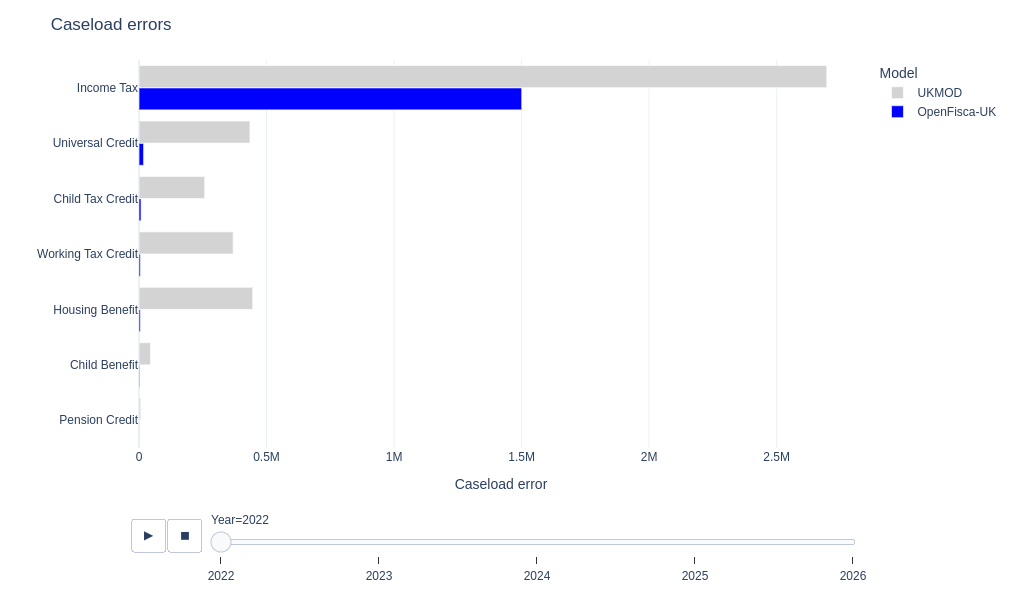

In [11]:
def error_chart(table, title=None):
    hovertemplate = "<b>%{customdata[4]} in %{customdata[3]}</b><br>Error: %{x}<br>Official: %{customdata[2]}m<br>OpenFisca-UK: %{customdata[0]}m<br>UKMOD: %{customdata[1]}m"
    table = table.replace("", np.nan).dropna(axis=0)
    table[[OPENFISCA_UK, UKMOD]] = table[[OPENFISCA_UK, UKMOD]].abs() / 1e2
    fig = (
        px.bar(
            table.sort_values(["Year", OPENFISCA_UK]),
            x=[OPENFISCA_UK, UKMOD],
            y="Program",
            orientation="h",
            animation_frame="Year",
            barmode="group",
            color_discrete_map={
                OPENFISCA_UK: "blue",
                UKMOD: "lightgrey",
            },
            custom_data=[
                "OpenFisca-UK caseload",
                "UKMOD caseload",
                "External caseload",
                "Year",
                "Program",
            ],
        )
        .update_layout(
            width=800,
            height=600,
            xaxis_title="Caseload error",
            title=title,
            template="plotly_white",
            legend_title="Model",
            yaxis_title="",
            legend_traceorder="reversed",
        )
        .update_traces(hovertemplate=hovertemplate)
    )
    for frame in fig.frames:
        for data in frame.data:
            data.hovertemplate = hovertemplate
    return fig


error_chart(
    tables_to_model_comparisons(
        {
            "": model_validation_table(
                caseload_error,
                models=[OPENFISCA_UK, UKMOD],
                decimals=1,
                divisor=1e-2,
            ),
            "caseload": model_validation_table(
                caseload, divisor=1e6, decimals=1
            ),
        }
    ),
    title="Caseload errors",
)

## Automated tests

Below are test results from the most recent version.

In [12]:
from openfisca_uk.tests.microsimulation.test_statistics import tests

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.DataFrame({"Name": tests, "Passed": [test.test()[0] for test in tests]})

,Name,Passed
0,OpenFisca-UK Child Benefit caseload error is less than 10.0% in 2019,True
1,OpenFisca-UK Child Benefit caseload error is less than 10.0% in 2020,True
2,OpenFisca-UK Child Benefit caseload error is less than 10.0% in 2021,True
3,OpenFisca-UK Child Benefit caseload error is less than 10.0% in 2022,True
4,OpenFisca-UK Council Tax (less CTB) aggregate error is less than 11.0% in 2019,True
5,OpenFisca-UK Council Tax (less CTB) aggregate error is less than 11.0% in 2020,True
6,OpenFisca-UK Council Tax (less CTB) aggregate error is less than 11.0% in 2021,True
7,OpenFisca-UK Council Tax (less CTB) aggregate error is less than 11.0% in 2022,True
8,OpenFisca-UK Child Tax Credit aggregate error is less than 40.0% in 2019,True
9,OpenFisca-UK Child Tax Credit aggregate error is less than 40.0% in 2020,True
